# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

In [2]:
df = pd.read_csv(r'C:\Users\Teng Li Yuan\Desktop\Leeds 2007-2014.csv')

In [3]:
df.head()

,Date,Hour,LocationName,Count,WeekDay,WeekNum,Month,Year
0,1/8/2007,0:00,Briggate,127,Wednesday,31,August,2007
1,1/8/2007,1:00,Briggate,52,Wednesday,31,August,2007
2,1/8/2007,2:00,Briggate,56,Wednesday,31,August,2007
3,1/8/2007,3:00,Briggate,56,Wednesday,31,August,2007
4,1/8/2007,4:00,Briggate,21,Wednesday,31,August,2007


In [4]:
df.dtypes

Date            object
Hour            object
LocationName    object
Count            int64
WeekDay         object
WeekNum          int64
Month           object
Year             int64
dtype: object

In [5]:
print(len(df['LocationName'].unique()))
df['LocationName'].unique()

8


array(['Briggate', 'Briggate at McDonalds\t', 'Commercial Street at Lush',
       'Albion Street North', 'Albion Street South', 'Dortmund Square\t',
       'Headrow', 'Commercial Street at Barratts'], dtype=object)

Year
2007     3936
2008    31224
2009    65256
2010    69888
2011    69888
2012    69888
2013    69888
2014     6144
dtype: int64


<AxesSubplot:xlabel='Year'>

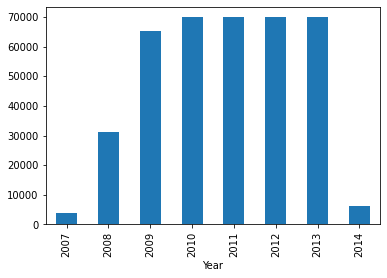

In [6]:
print(df.groupby('Year').size())
df.groupby('Year').size().plot.bar()

In [7]:
df.isnull().sum()

# No null value... That's great..!

Date            0
Hour            0
LocationName    0
Count           0
WeekDay         0
WeekNum         0
Month           0
Year            0
dtype: int64

There are 8 columns, which is:

__Date,	Hour,	LocationName,	Count,	WeekDay,	WeekNum,	Month,	Year__

There are some missing records on before 2010 and after 2014.
This is due to some cameras were not operate for a whole year before 2010.

Therefore, only footfall data of 5 years timeframe  from 2010-2014 will be selected.

# Visualisation

In [8]:
df['Date'] = pd.to_datetime(df['Date'] + ' '+df['Hour'])

In [9]:
df = df.set_index('Date')

In [10]:
df_ASN = df[df['LocationName']=='Albion Street North']

In [11]:
df_ASN_1013 = df_ASN['2010':'2013']

In [12]:
df_ASN_1013.head()

,Hour,LocationName,Count,WeekDay,WeekNum,Month,Year
Date,,,,,,,
2010-01-01 00:00:00,0:00,Albion Street North,5,Friday,53,December,2009
2010-01-01 01:00:00,1:00,Albion Street North,27,Friday,53,December,2009
2010-01-01 02:00:00,2:00,Albion Street North,8,Friday,53,December,2009
2010-01-01 03:00:00,3:00,Albion Street North,15,Friday,53,December,2009
2010-01-01 04:00:00,4:00,Albion Street North,6,Friday,53,December,2009


In [13]:
df_ASN_1013.drop(['Hour','LocationName','WeekDay','WeekNum','Month','Year'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


<AxesSubplot:xlabel='Date'>

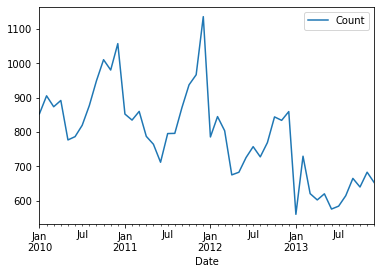

In [14]:
df_ASN_1013.resample('M').mean().plot()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


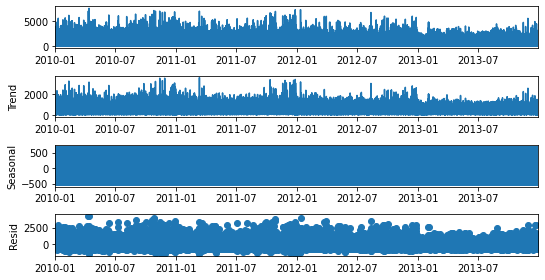

In [15]:
res = sm.tsa.seasonal_decompose(df_ASN_1013,freq=12)
fig = res.plot()
fig.set_figheight(4)
fig.set_figwidth(8)
plt.show()

<AxesSubplot:>

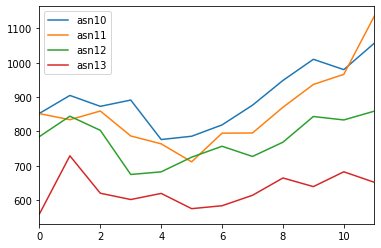

In [16]:
df1 = pd.DataFrame()

df1['asn10'] = df_ASN_1013['2010'].resample('M').mean().reset_index()['Count']
df1['asn11'] = df_ASN_1013['2011'].resample('M').mean().reset_index()['Count']
df1['asn12'] = df_ASN_1013['2012'].resample('M').mean().reset_index()['Count']
df1['asn13'] = df_ASN_1013['2013'].resample('M').mean().reset_index()['Count']

df1.plot()

From the plot above, we observed the time-series data has a __down-trend seasonal pattern__.

The footfall count were low around May and peak at year-end.
This is possibily related to the two major holidays in UK: __Easter__ (Early April) and __Christmas__(Dec)

The pattern and some possible reasons are:
1. Christmas:
    The footfall count increased from July - December and subsequently drop drastically in Jan.
    After Christmas carnival, there are less visitors attracted to the street. Possibly there are less sales and promotion in the shops, or people's desire to shop has reduced.
    
2. Easter:
    Despite the low at post-Christmas month, there is a increase of visitors to these street in March to prepare for Easter celebration

# Arima and Seasonal ARIMA

The general process of ARIMA model is
1. Time series stationary
2. Plot the correlation and autocorrelation charts
3. Construnct ARIMA or Seasonal Arima
4. Prediciton

Link: https://www.youtube.com/watch?v=Aw77aMLj9uM&ab_channel=AnalyticsUniversity
Link: https://otexts.com/fpp2/tspatterns.html

Before we get started with the stationarity of the time-series data, let's get started with the time series pattern:
1. Trend - A long term relatively smooth pattern that usually persist for more than a year. Long tern increase or decrease
2. Seasonal - Pattern occur in regular interval within a year or even shorter, or day of a week.
3. Cyclical - Pattern beyond a freq of one year (or fluctuation of non-fixed interval)
4. Random - None of above


Link: https://machinelearningmastery.com/time-series-data-stationary-python/
Stationary time series are not dependent on time, i.e. there are no trend or seasonal effect.

## Time Series Stationary

In [17]:
### Testing For Stationarity
## Link: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
## https://machinelearningmastery.com/time-series-data-stationary-python/

from statsmodels.tsa.stattools import adfuller

In [18]:
df_ASN_1013 = df_ASN_1013.resample('M').mean()

In [19]:
test_result=adfuller(df_ASN_1013['Count'])
test_result

(-1.7779777691908196,
 0.39144862212557024,
 1,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 443.3217740147237)

In [20]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [21]:
adfuller_test(df_ASN_1013['Count'])

ADF Test Statistic : -1.7779777691908196
p-value : 0.39144862212557024
#Lags Used : 1
Number of Observations Used : 46
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Differencing - making the series to be stationary
We now confirm it is a non-stationary time-series because its p-value > 0.05 and failed to reject the null hypothesis.

In [22]:
df_ASN_1013['Count 12 mth diff'] = df_ASN_1013['Count']-df_ASN_1013['Count'].shift(12)

In [23]:
#adfuller_test(df_ASN_1013.dropna()['Count 12 mth diff'])

In [24]:
adfuller_test(df_ASN_1013['Count'].diff().dropna())

ADF Test Statistic : -6.328022397404558
p-value : 2.9532793409342778e-08
#Lags Used : 10
Number of Observations Used : 36
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Now it is stationary

In [25]:
train = pd.Series(df_ASN_1013['Count'].reset_index()['Count'])

In [26]:
from statsmodels.tsa.arima_model import ARIMA

In [27]:
## Checking pdq parameter 

from pmdarima.arima import auto_arima

model_autoarima = auto_arima(test, seasonal=True,m=12)
#m = 12 as data contains daily observations

NameError: name 'test' is not defined

In [ ]:
model_autoarima.summary()

In [ ]:
## https://medium.com/@shawanugya12/implementation-of-time-series-forecasting-methods-sarima-sarimax-and-prophet-ff8407b25aaa

In [ ]:
# ## Use order select to find the pqr https://www.kaggle.com/poiupoiu/how-to-use-sarimax
df_ASN_1013.drop('Count 12 mth diff', axis = 1, inplace=True)

In [ ]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_ASN_1013,order=(0, 1, 1),seasonal_order=(1,0,0,12))
results=model.fit()
df_predict = results.predict(start='2014',end='2016',dynamic=True)
df_predict.plot()

#Model:	SARIMAX(0, 1, 1)x(1, 0, 0, 12)	

In [ ]:
df_predict=pd.DataFrame( {'Count' : df_predict})

# Visualisation of the Prediction result

In [ ]:
pd.concat([df_ASN_1013, pd.DataFrame(df_predict)]).plot()